In [28]:
%matplotlib inline


Transfer Learning for Computer
==============================================
**Reference**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. The rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [15]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import roc_auc_score

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.


In [16]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),

    ]),
}

data_dir = '/home/kaiyihuang/nexperia/new_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

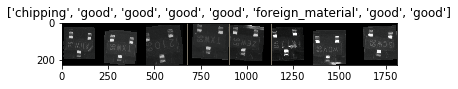

In [23]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [17]:
def perf_measure_bad(y_actual, y_hat):
    TP = torch.mul(y_actual!=4,y_hat!=4).sum().item()
    FP = torch.mul(y_actual==4,y_hat!=4).sum().item()
    TN = torch.mul(y_actual==4,y_hat==4).sum().item()
    FN = torch.mul(y_actual!=4,y_hat==4).sum().item()    

    return (TP, FP, TN, FN)

In [18]:
def perf_measure_fm(y_actual, y_hat):
    TN = torch.mul(y_actual!=3,y_hat!=3).sum().item()
    FN = torch.mul(y_actual==3,y_hat!=3).sum().item()
    TP = torch.mul(y_actual==3,y_hat==3).sum().item()
    FP = torch.mul(y_actual!=3,y_hat==3).sum().item()    

    return (TP, FP, TN, FN)

In [19]:
def good_to_false_fm(y_actual, y_hat):
    f_fm = torch.mul(y_actual==4,y_hat==3).sum().item()
    
    return f_fm

In [20]:
# metrics (TPR, TNR) weights
good = sum(class_idx==4 for class_idx in image_datasets['train'].targets) / len(image_datasets['train'])
bad = (len(image_datasets['train']) - sum(class_idx==4 for class_idx in image_datasets['train'].targets)) / len(image_datasets['train'])

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, save_path):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc_bad_fm = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            running_TP = 0
            running_FP = 0
            running_TN = 0
            running_FN = 0

            running_TP_fm = 0
            running_FP_fm = 0
            running_TN_fm = 0
            running_FN_fm = 0
            
            running_f_fm = 0
            
            y_true = []
            y_pred = []
            
            # Iterate over data.
            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                TP, FP, TN, FN = perf_measure_bad(labels.data,preds)            
                running_TP += TP
                running_FP += FP
                running_TN += TN
                running_FN += FN
                
                TP_fm, FP_fm, TN_fm, FN_fm = perf_measure_fm(labels.data,preds)            
                running_TP_fm += TP_fm
                running_FP_fm += FP_fm
                running_TN_fm += TN_fm
                running_FN_fm += FN_fm
                
                f_fm = good_to_false_fm(labels.data,preds)
                running_f_fm += f_fm

                m = nn.Softmax(dim=1)
                probs = m(outputs)
                
                y_true.append(labels.detach().cpu())
                y_pred.append(probs.detach().cpu())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if (running_TP+running_FN==0):
                epoch_TPR = float('nan')
            else:
                epoch_TPR = running_TP / (running_TP + running_FN)
            if (running_TN+running_FP==0):
                epoch_TNR = float('nan')
            else:
                epoch_TNR = running_TN / (running_TN + running_FP)
                
            if (running_TP_fm+running_FN_fm==0):
                epoch_TPR_fm = float('nan')
            else:
                epoch_TPR_fm = running_TP_fm / (running_TP_fm + running_FN_fm)
            if (running_TN_fm+running_FP_fm==0):
                epoch_TNR_fm = float('nan')
            else:
                epoch_TNR_fm = running_TN_fm / (running_TN_fm + running_FP_fm)
            
            if (running_FP==0):
                epoch_f_fm_rate = float('nan')
            else:
                epoch_f_fm_rate = running_f_fm / running_FP

            y_true = torch.cat(y_true)
            y_pred = torch.cat(y_pred)
            y_bad = y_true!=4
            y_fm = y_true==3
            y_bad_score = torch.cat((y_pred[:,:4],y_pred[:,5:]),1).sum(1)
            y_fm_score = y_pred[:,3]
            epoch_auc_bad = roc_auc_score(y_bad, y_bad_score,average='weighted')
            epoch_auc_fm = roc_auc_score(y_fm, y_fm_score,average='weighted')
            epoch_auc = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')

            print('{} Loss: {:.4f} Acc: {:.4f} TPR: {:.4f} TNR: {:.4f} TPR_fm: {:.4f} TNR_fm: {:.4f} fm/FP: {:.4f}'
                  .format(phase, epoch_loss, epoch_acc, epoch_TPR, epoch_TNR,
                          epoch_TPR_fm, epoch_TNR_fm, epoch_f_fm_rate))
            print('{} AUC_bad: {:.4f} AUC_fm {:.4f} AUC: {:.4f}'
                  .format(' '*len(phase), epoch_auc_bad, epoch_auc_fm, epoch_auc))

            # deep copy the model
            epoch_auc_bad_fm = (epoch_auc_bad + epoch_auc_fm) / 2
            if phase == 'val' and epoch_auc_bad_fm > best_auc_bad_fm:
                epoch_auc_bad_fm = best_auc_bad_fm
                best_epoch = epoch
                best_acc = epoch_acc
                best_TPR = epoch_TPR
                best_TNR = epoch_TNR
                best_TPR_fm = epoch_TPR_fm
                best_TNR_fm = epoch_TNR_fm
                best_f_fm_rate = epoch_f_fm_rate
                best_auc_bad = epoch_auc_bad
                best_auc_fm = epoch_auc_fm
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'best_val_acc': epoch_acc,
                            'val_loss': epoch_loss,
                            'val_TPR': epoch_TPR,
                            'val_TNR': epoch_TNR,
                            'val_TPR_fm': epoch_TPR_fm,
                            'val_TNR_fm': epoch_TNR_fm,
                            'val_fm/FP': epoch_f_fm_rate,
                            'val_auc_bad': epoch_auc_bad,
                            'val_auc_fm': epoch_auc_fm,
                            'val_auc': epoch_auc
                            }, save_path)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best epoch: {:d}'.format(best_epoch+1))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val TPR: {:4f}'.format(best_TPR))
    print('Best val TNR: {:4f}'.format(best_TNR))
    print('Best val TPR_fm: {:4f}'.format(best_TPR_fm))
    print('Best val TNR_fm: {:4f}'.format(best_TNR_fm))
    print('Best val fm/FP: {:4f}'.format(best_f_fm_rate))
    print('Best val AUC_bad: {:4f}'.format(best_auc_bad))
    print('Best val AUC_fm: {:4f}'.format(best_auc_fm))
    print('Best val AUC: {:4f}'.format(best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [44]:
def train_model_good_bad(model, criterion, optimizer, scheduler, num_epochs, save_path):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            running_TP = 0
            running_FP = 0
            running_TN = 0
            running_FN = 0
            
            y_true = []
            y_pred = []
            
            # Iterate over data.
            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                
                labels = (labels!=4).type(torch.LongTensor)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                TP = torch.mul(labels.data==1,preds==1).sum().item()
                FP = torch.mul(labels.data==0,preds==1).sum().item()
                TN = torch.mul(labels.data==0,preds==0).sum().item()
                FN = torch.mul(labels.data==1,preds==0).sum().item()
                
                running_TP += TP
                running_FP += FP
                running_TN += TN
                running_FN += FN
                
                m = nn.Softmax(dim=1)
                probs = m(outputs)
                
                y_true.append(labels.detach().cpu())
                y_pred.append(probs.detach().cpu())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if (running_TP+running_FN==0):
                epoch_TPR = float('nan')
            else:
                epoch_TPR = running_TP / (running_TP + running_FN)
            if (running_TN+running_FP==0):
                epoch_TNR = float('nan')
            else:
                epoch_TNR = running_TN / (running_TN + running_FP)
                
            y_true = torch.cat(y_true)
            y_pred = torch.cat(y_pred)[:,1]

            epoch_auc = roc_auc_score(y_true, y_pred,average='weighted',multi_class='ovr')

            print('{} Loss: {:.4f} Acc: {:.4f} TPR: {:.4f} TNR: {:.4f} AUC: {:.4f}'
                  .format(phase, epoch_loss, epoch_acc, epoch_TPR, epoch_TNR, epoch_auc))

            # deep copy the model
            if phase == 'val' and epoch_auc > best_auc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_TPR = epoch_TPR
                best_TNR = epoch_TNR
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'best_val_acc': epoch_acc,
                            'val_loss': epoch_loss,
                            'val_TPR': epoch_TPR,
                            'val_TNR': epoch_TNR,
                            'val_auc': epoch_auc
                            }, save_path)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best epoch: {:d}'.format(best_epoch+1))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val TPR: {:4f}'.format(best_TPR))
    print('Best val TNR: {:4f}'.format(best_TNR))
    print('Best val AUC: {:4f}'.format(best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, actual: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [24]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [45]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
# weighted loss function
weights = []
for i in range(len(class_names)):
    weight =  sum(class_idx==i for class_idx in image_datasets['train'].targets)
#     # give heavier penalty to failure to find foreign material
#     if i==3:
#         weight /= 10
    
    # heavier penalty to failure to detect bad images, even heavier for foreign material
    if i!=4:
        weight /= 10
        if i==3:
            weight /= 10
    weights.append(weight)
weight_sum = sum(weights)
weights = torch.tensor([weight_sum / weight for weight in weights])
weights = weights.to(device)
criterion_weighted = nn.CrossEntropyLoss(weight=torch.tensor(weights))

/home/kaiyihuang/.conda/envs/tensorflow2_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [21]:
image_datasets['train'].class_to_idx

{'chipping': 0,
 'device_flip': 1,
 'empty_pocket': 2,
 'foreign_material': 3,
 'good': 4,
 'lead_defect': 5,
 'lead_glue': 6,
 'marking_defect': 7,
 'pocket_damage': 8,
 'scratch': 9}

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [46]:
# 2 output classes no weight
model_ft = train_model_good_bad(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_dict_2_classes.pt')

Epoch 1/50
----------
train Loss: 0.1968 Acc: 0.9222 TPR: 0.7327 TNR: 0.9704 AUC: 0.9575
val Loss: 0.1002 Acc: 0.9661 TPR: 0.9414 TNR: 0.9723 AUC: 0.9917

Epoch 2/50
----------
train Loss: 0.1014 Acc: 0.9654 TPR: 0.8980 TNR: 0.9825 AUC: 0.9886
val Loss: 0.0721 Acc: 0.9756 TPR: 0.9514 TNR: 0.9818 AUC: 0.9952

Epoch 3/50
----------
train Loss: 0.0778 Acc: 0.9731 TPR: 0.9245 TNR: 0.9854 AUC: 0.9926
val Loss: 0.0709 Acc: 0.9762 TPR: 0.9143 TNR: 0.9920 AUC: 0.9950

Epoch 4/50
----------
train Loss: 0.0621 Acc: 0.9786 TPR: 0.9413 TNR: 0.9881 AUC: 0.9955
val Loss: 0.0584 Acc: 0.9797 TPR: 0.9671 TNR: 0.9829 AUC: 0.9972

Epoch 5/50
----------
train Loss: 0.0579 Acc: 0.9804 TPR: 0.9489 TNR: 0.9884 AUC: 0.9959
val Loss: 0.0517 Acc: 0.9832 TPR: 0.9443 TNR: 0.9931 AUC: 0.9973

Epoch 6/50
----------
train Loss: 0.0479 Acc: 0.9837 TPR: 0.9570 TNR: 0.9905 AUC: 0.9971
val Loss: 0.0521 Acc: 0.9803 TPR: 0.9400 TNR: 0.9905 AUC: 0.9975

Epoch 7/50
----------
train Loss: 0.0458 Acc: 0.9845 TPR: 0.9597 TNR: 

In [36]:
model_ft_weighted = train_model(model_ft, criterion_weighted, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_dict_weighted_overall_heavier_penalty_esp_for_fm.pt')

Epoch 1/50
----------


RuntimeError: weight tensor should be defined either for all 2 classes or no classes but got weight tensor of shape: [10] at /opt/conda/conda-bld/pytorch_1587428398394/work/aten/src/THCUNN/generic/ClassNLLCriterion.cu:47

In [95]:
model_ft_weighted = train_model(model_ft, criterion_weighted, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_dict_weighted_heavier_penalty_fm.pt')

Epoch 1/50
----------
train Loss: 1.0224 Acc: 0.4580 TPR: 0.9492 TNR: 0.4477 TPR_fm: 0.8786 TNR_fm: 0.6340 fm/FP: 0.6452
      AUC_bad: 0.8524 AUC_fm 0.8645 AUC: 0.8437
val Loss: 0.6787 Acc: 0.8549 TPR: 0.8571 TNR: 0.9050 TPR_fm: 0.8409 TNR_fm: 0.9551 fm/FP: 0.3640
    AUC_bad: 0.9527 AUC_fm 0.9684 AUC: 0.9535

Epoch 2/50
----------
train Loss: 0.6101 Acc: 0.7429 TPR: 0.9535 TNR: 0.7551 TPR_fm: 0.9013 TNR_fm: 0.8584 fm/FP: 0.5306
      AUC_bad: 0.9533 AUC_fm 0.9530 AUC: 0.9501
val Loss: 0.6271 Acc: 0.4946 TPR: 0.9986 TNR: 0.4296 TPR_fm: 0.9205 TNR_fm: 0.8802 fm/FP: 0.1978
    AUC_bad: 0.9699 AUC_fm 0.9637 AUC: 0.9640

Epoch 3/50
----------
train Loss: 0.4958 Acc: 0.8112 TPR: 0.9705 TNR: 0.8249 TPR_fm: 0.9292 TNR_fm: 0.8957 fm/FP: 0.5348
      AUC_bad: 0.9739 AUC_fm 0.9690 AUC: 0.9719
val Loss: 0.5242 Acc: 0.7934 TPR: 0.9914 TNR: 0.7910 TPR_fm: 0.9034 TNR_fm: 0.9028 fm/FP: 0.4774
    AUC_bad: 0.9814 AUC_fm 0.9639 AUC: 0.9776

Epoch 4/50
----------
train Loss: 0.4562 Acc: 0.8268 TPR: 0.9

In [90]:
model_ft_weighted = train_model(model_ft, criterion_weighted, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_dict_weighted.pt')

Epoch 1/50
----------
train Loss: 1.1554 Acc: 0.6596 TPR: 0.9018 TNR: 0.6800 TPR_fm: 0.5971 TNR_fm: 0.9503 fm/FP: 0.1389
             AUC_bad: 0.9055 AUC_fm 0.8939 AUC: 0.9009
val Loss: 0.8944 Acc: 0.7702 TPR: 0.9814 TNR: 0.7739 TPR_fm: 0.5455 TNR_fm: 0.9841 fm/FP: 0.0741
           AUC_bad: 0.9781 AUC_fm 0.9461 AUC: 0.9726

Epoch 2/50
----------
train Loss: 0.7207 Acc: 0.8156 TPR: 0.9522 TNR: 0.8368 TPR_fm: 0.7280 TNR_fm: 0.9700 fm/FP: 0.1645
             AUC_bad: 0.9694 AUC_fm 0.9539 AUC: 0.9671
val Loss: 0.7599 Acc: 0.7679 TPR: 0.9757 TNR: 0.7878 TPR_fm: 0.6818 TNR_fm: 0.9789 fm/FP: 0.0961
           AUC_bad: 0.9790 AUC_fm 0.9636 AUC: 0.9755

Epoch 3/50
----------
train Loss: 0.5598 Acc: 0.8577 TPR: 0.9622 TNR: 0.8794 TPR_fm: 0.7609 TNR_fm: 0.9724 fm/FP: 0.2083
             AUC_bad: 0.9813 AUC_fm 0.9680 AUC: 0.9794
val Loss: 0.5525 Acc: 0.9106 TPR: 0.9586 TNR: 0.9396 TPR_fm: 0.6932 TNR_fm: 0.9869 fm/FP: 0.1867
           AUC_bad: 0.9902 AUC_fm 0.9760 AUC: 0.9886

Epoch 4/50
--------

In [29]:
model_ft_weighted = train_model(model_ft, criterion_weighted, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_dict_weighted_batch_size_8.pt')

Epoch 1/50
----------
train Loss: 1.0289 Acc: 0.7917 TPR: 0.8453 TNR: 0.8399
val Loss: 1.1444 Acc: 0.7456 TPR: 0.9529 TNR: 0.7779

Epoch 2/50
----------
train Loss: 0.6001 Acc: 0.9004 TPR: 0.9248 TNR: 0.9347
val Loss: 0.6862 Acc: 0.8880 TPR: 0.9771 TNR: 0.9170

Epoch 3/50
----------
train Loss: 0.5032 Acc: 0.9162 TPR: 0.9452 TNR: 0.9454
val Loss: 0.4187 Acc: 0.9289 TPR: 0.9729 TNR: 0.9490

Epoch 4/50
----------
train Loss: 0.4621 Acc: 0.9225 TPR: 0.9503 TNR: 0.9498
val Loss: 0.4295 Acc: 0.9370 TPR: 0.9629 TNR: 0.9676

Epoch 5/50
----------
train Loss: 0.4198 Acc: 0.9283 TPR: 0.9575 TNR: 0.9539
val Loss: 0.4832 Acc: 0.9504 TPR: 0.9571 TNR: 0.9774

Epoch 6/50
----------
train Loss: 0.3785 Acc: 0.9389 TPR: 0.9670 TNR: 0.9624
val Loss: 0.4388 Acc: 0.9428 TPR: 0.9729 TNR: 0.9661

Epoch 7/50
----------
train Loss: 0.3539 Acc: 0.9390 TPR: 0.9714 TNR: 0.9614
val Loss: 0.4642 Acc: 0.9463 TPR: 0.9643 TNR: 0.9698

Epoch 8/50
----------
train Loss: 0.2562 Acc: 0.9572 TPR: 0.9808 TNR: 0.9752
val Lo

In [23]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_dict.pt')

Epoch 1/50
----------
train Loss: 0.4209 Acc: 0.8795 TPR: 0.6150 TNR: 0.9839 TPR_fm: 0.5041 TNR_fm: 0.9875 fm/FP: 0.2166
      AUC_bad: 0.9458 AUC_fm 0.9316 AUC: 0.9416
val Loss: 0.2480 Acc: 0.9278 TPR: 0.8214 TNR: 0.9909 TPR_fm: 0.6136 TNR_fm: 0.9902 fm/FP: 0.2000
    AUC_bad: 0.9867 AUC_fm 0.9730 AUC: 0.9844

Epoch 2/50
----------
train Loss: 0.2148 Acc: 0.9356 TPR: 0.8576 TNR: 0.9876 TPR_fm: 0.7419 TNR_fm: 0.9879 fm/FP: 0.3497
      AUC_bad: 0.9883 AUC_fm 0.9808 AUC: 0.9866
val Loss: 0.1845 Acc: 0.9443 TPR: 0.9271 TNR: 0.9829 TPR_fm: 0.8693 TNR_fm: 0.9774 fm/FP: 0.6596
    AUC_bad: 0.9943 AUC_fm 0.9877 AUC: 0.9928

Epoch 3/50
----------
train Loss: 0.1718 Acc: 0.9468 TPR: 0.9013 TNR: 0.9895 TPR_fm: 0.7932 TNR_fm: 0.9896 fm/FP: 0.3577
      AUC_bad: 0.9931 AUC_fm 0.9859 AUC: 0.9917
val Loss: 0.1636 Acc: 0.9504 TPR: 0.9157 TNR: 0.9924 TPR_fm: 0.8466 TNR_fm: 0.9810 fm/FP: 0.6190
    AUC_bad: 0.9968 AUC_fm 0.9885 AUC: 0.9951

Epoch 4/50
----------
train Loss: 0.1484 Acc: 0.9537 TPR: 0.9

In [11]:
model_ft.load_state_dict(torch.load('resnet_18_dict.pt')['model_state_dict'])

<All keys matched successfully>

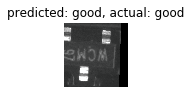

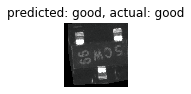

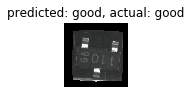

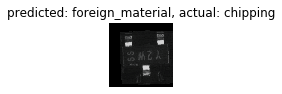

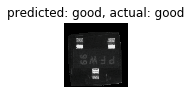

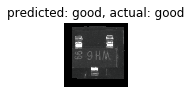

In [14]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [15]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 1/50
----------
train Loss: 0.7319 Acc: 0.7995 TPR: 0.0530 TNR: 0.9954
val Loss: 0.6730 Acc: 0.8063 TPR: 0.1311 TNR: 0.9912

Epoch 2/50
----------
train Loss: 0.6524 Acc: 0.8105 TPR: 0.1470 TNR: 0.9905
val Loss: 0.6353 Acc: 0.8175 TPR: 0.1915 TNR: 0.9875

Epoch 3/50
----------
train Loss: 0.6325 Acc: 0.8156 TPR: 0.1967 TNR: 0.9865
val Loss: 0.6241 Acc: 0.8201 TPR: 0.1864 TNR: 0.9928

Epoch 4/50
----------
train Loss: 0.6211 Acc: 0.8191 TPR: 0.2224 TNR: 0.9855
val Loss: 0.6095 Acc: 0.8172 TPR: 0.1645 TNR: 0.9961

Epoch 5/50
----------
train Loss: 0.6100 Acc: 0.8210 TPR: 0.2440 TNR: 0.9842
val Loss: 0.6094 Acc: 0.8183 TPR: 0.2159 TNR: 0.9882

Epoch 6/50
----------
train Loss: 0.6058 Acc: 0.8228 TPR: 0.2527 TNR: 0.9843
val Loss: 0.6019 Acc: 0.8266 TPR: 0.3483 TNR: 0.9725

Epoch 7/50
----------
train Loss: 0.6005 Acc: 0.8213 TPR: 0.2615 TNR: 0.9815
val Loss: 0.6130 Acc: 0.8201 TPR: 0.1954 TNR: 0.9905

Epoch 8/50
----------
train Loss: 0.5910 Acc: 0.8258 TPR: 0.2598 TNR: 0.9855
val Lo

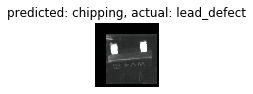

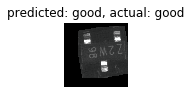

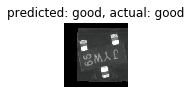

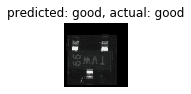

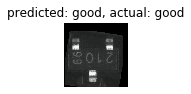

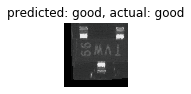

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [3]:
! nvidia-smi

Wed May 13 08:51:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 440.44       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 16%   29C    P5    14W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 19%   29C    P5    14W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50,save_path='resnet_18_dict.pt')

Epoch 1/50
----------
train Loss: 0.3909 Acc: 0.8884 TPR: 0.6342 TNR: 0.9859
val Loss: 0.2235 Acc: 0.9360 TPR: 0.8933 TNR: 0.9879

Epoch 2/50
----------
train Loss: 0.1993 Acc: 0.9407 TPR: 0.8810 TNR: 0.9882
val Loss: 0.1750 Acc: 0.9452 TPR: 0.8882 TNR: 0.9938

Epoch 3/50
----------
train Loss: 0.1646 Acc: 0.9502 TPR: 0.9127 TNR: 0.9902
val Loss: 0.1533 Acc: 0.9535 TPR: 0.9447 TNR: 0.9908

Epoch 4/50
----------
train Loss: 0.1398 Acc: 0.9569 TPR: 0.9319 TNR: 0.9913
val Loss: 0.1483 Acc: 0.9538 TPR: 0.9165 TNR: 0.9944

Epoch 5/50
----------
train Loss: 0.1233 Acc: 0.9607 TPR: 0.9427 TNR: 0.9921
val Loss: 0.1327 Acc: 0.9564 TPR: 0.9434 TNR: 0.9931

Epoch 6/50
----------
train Loss: 0.1159 Acc: 0.9629 TPR: 0.9464 TNR: 0.9924
val Loss: 0.1296 Acc: 0.9619 TPR: 0.9756 TNR: 0.9872

Epoch 7/50
----------
train Loss: 0.1086 Acc: 0.9653 TPR: 0.9527 TNR: 0.9922
val Loss: 0.1336 Acc: 0.9590 TPR: 0.9550 TNR: 0.9905

Epoch 8/50
----------
train Loss: 0.0894 Acc: 0.9710 TPR: 0.9629 TNR: 0.9941
val Lo

In [26]:
print(models.resnet18(pretrained=True))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  